In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2, exp, log1p, expm1
from datetime import timedelta


FILE1_PATH = "../data/1990-2000.csv"
FILE2_PATH = "../data/2000-2025.csv"


def load_and_preprocess_data(file1_path, file2_path):
    """Veriyi yükler, birleştirir ve temel ön işlemeleri yapar."""
    try:
        df1 = pd.read_csv(file1_path)
        df2 = pd.read_csv(file2_path)
    except FileNotFoundError:
        print(
            f"HATA: Veri dosyaları bulunamadı. Lütfen dosya yollarını kontrol edin: {file1_path}, {file2_path}"
        )
        return None

    df = pd.concat([df1, df2], ignore_index=True)

    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df.dropna(subset=["time"], inplace=True)

    required_cols = ["latitude", "longitude", "depth", "mag"]
    df.dropna(subset=required_cols, inplace=True)

    df["mag"] = pd.to_numeric(df["mag"], errors="coerce")
    df.dropna(subset=["mag"], inplace=True)

    df = df.sort_values(by="time").reset_index(drop=True)

    df = df[["time", "latitude", "longitude", "depth", "mag"]]

    print(f"Toplam {len(df)} deprem verisi yüklendi ve işlendi.")
    print("İlk 5 satır:\n", df.head())
    print("\nVeri tipleri:\n", df.dtypes)
    print(f"\nMinimum Tarih: {df['time'].min()}, Maksimum Tarih: {df['time'].max()}")
    return df


def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1_rad = radians(lat1)
    lat2_rad = radians(lat2)
    a = sin(dLat / 2) ** 2 + cos(lat1_rad) * cos(lat2_rad) * sin(dLon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance


df_earthquakes = load_and_preprocess_data(FILE1_PATH, FILE2_PATH)

if df_earthquakes is None:
    print("Veri yüklenemediği için işlem durduruluyor.")

Toplam 32166 deprem verisi yüklendi ve işlendi.
İlk 5 satır:
                               time  latitude  longitude  depth  mag
0 1990-01-01 02:47:41.250000+00:00    36.323     26.969  144.8  3.3
1 1990-01-02 20:35:41.790000+00:00    38.607     24.194   10.0  4.6
2 1990-01-02 21:46:47.240000+00:00    36.118     27.210    5.0  3.6
3 1990-01-02 23:24:34.080000+00:00    36.596     25.651   26.4  4.4
4 1990-01-05 05:25:13.040000+00:00    38.663     26.155   10.0  3.2

Veri tipleri:
 time         datetime64[ns, UTC]
latitude                 float64
longitude                float64
depth                    float64
mag                      float64
dtype: object

Minimum Tarih: 1990-01-01 02:47:41.250000+00:00, Maksimum Tarih: 2025-05-22 03:19:35.341000+00:00


In [ ]:
def identify_mainshock_aftershock_sequences(df, mainshock_min_mag=5.5, radius_km=150, time_window_days=30):
    """
    Ana şokları ve onlara bağlı artçı şok dizilerini tanımlar.
    Her ana şok için, zaman ve mekan penceresindeki İLK artçıyı hedefler.
    """
    if df is None or df.empty:
        print("Deprem verisi boş veya yüklenememiş.")
        return pd.DataFrame()

    
    potential_mainshocks = df[df['mag'] >= mainshock_min_mag].copy()
    print(f"Potansiyel ana şok sayısı (M>={mainshock_min_mag}): {len(potential_mainshocks)}")

    training_samples = []
    processed_event_indices = set() 

    for idx, mainshock in potential_mainshocks.iterrows():
        if idx in processed_event_indices:
            continue 

        mainshock_time = mainshock['time']
        mainshock_lat = mainshock['latitude']
        mainshock_lon = mainshock['longitude']
        mainshock_mag = mainshock['mag']
        mainshock_depth = mainshock['depth']

        
        time_window_end = mainshock_time + timedelta(days=time_window_days)

        
        potential_aftershocks_df = df[
            (df['time'] > mainshock_time) &
            (df['time'] <= time_window_end) &
            (df.index != idx) & 
            (df['mag'] < mainshock_mag) 
        ].copy()

        if potential_aftershocks_df.empty:
            continue

        
        potential_aftershocks_df['distance_to_mainshock'] = potential_aftershocks_df.apply(
            lambda row: haversine(mainshock_lat, mainshock_lon, row['latitude'], row['longitude']),
            axis=1
        )

        
        actual_aftershocks = potential_aftershocks_df[
            potential_aftershocks_df['distance_to_mainshock'] <= radius_km
        ].sort_values(by='time') 

        if not actual_aftershocks.empty:
            first_aftershock = actual_aftershocks.iloc[0]

            
            
            
            if first_aftershock.name in processed_event_indices:
                continue 

            time_to_first_aftershock_hours = (first_aftershock['time'] - mainshock_time).total_seconds() / 3600.0

            training_samples.append({
                'mainshock_mag': mainshock_mag,
                'mainshock_depth': mainshock_depth,
                'mainshock_lat': mainshock_lat, 
                'mainshock_lon': mainshock_lon, 
                'aftershock_mag': first_aftershock['mag'],
                'time_to_aftershock_hours': time_to_first_aftershock_hours,
                'mainshock_id': idx, 
                'aftershock_id': first_aftershock.name 
            })
            processed_event_indices.add(idx) 
            processed_event_indices.add(first_aftershock.name) 

    feature_df = pd.DataFrame(training_samples)
    print(f"\nOluşturulan eğitim örneği sayısı: {len(feature_df)}")
    if not feature_df.empty:
        print("Örnek eğitim verisi:\n", feature_df.head())
    return feature_df


if df_earthquakes is not None:
    feature_df = identify_mainshock_aftershock_sequences(df_earthquakes)
else:
    feature_df = pd.DataFrame() 

Potansiyel ana şok sayısı (M>=5.5): 186

Oluşturulan eğitim örneği sayısı: 169
Örnek eğitim verisi:
    mainshock_mag  mainshock_depth  mainshock_lat  mainshock_lon  \
0            5.5             17.2         36.990         29.595   
1            5.5             33.0         41.361         43.715   
2            5.6             22.7         34.825         26.335   
3            7.0             17.2         42.453         43.673   
4            5.5             10.0         42.583         43.764   

   aftershock_mag  time_to_aftershock_hours  mainshock_id  aftershock_id  
0             4.3                  0.153564           402            403  
1             4.1                173.719447           908            930  
2             4.2                  7.957019          1343           1345  
3             4.9                  0.413656          1507           1508  
4             4.5                  0.730128          1531           1533  



Toplam 169 eğitim örneği ile devam ediliyor.
Eğitim seti: 126, Test seti: 43

==================== LightGBM Modelleri ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] Start training from score 4.300000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

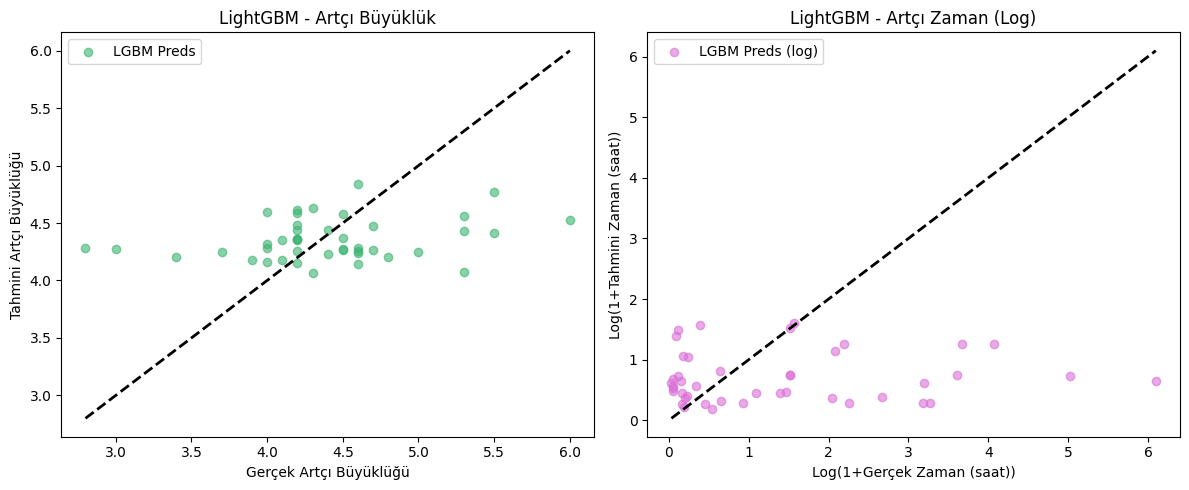


==================== MODEL TESTİ (ÖRNEK ANA ŞOK) ====================
    mainshock_mag  mainshock_depth  mainshock_lat  mainshock_lon
2             5.6             22.7         34.825         26.335
9             5.9             20.9         39.532         39.929
12            6.4             16.4         42.589         45.104
15            5.5             17.3         38.664         26.542
16            5.9             10.0         35.046         32.279
Test Ana Şok Bilgileri: Büyüklük=5.9, Derinlik=10.0 km, Enlem=39.42, Boylam=40.71
  -> Gerçek İlk Artçı: Büyüklük=4.50, Süre=0.17 saat
  -> LGBM Tahmini: Büyüklük=4.26, Süre=0.56 saat


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


trained_lgbm_mag_pipe = None


trained_lgbm_time_pipe = None


if not feature_df.empty and len(feature_df) > 10:

    print(f"\nToplam {len(feature_df)} eğitim örneği ile devam ediliyor.")

    X = feature_df[
        ["mainshock_mag", "mainshock_depth", "mainshock_lat", "mainshock_lon"]
    ]

    y_mag = feature_df["aftershock_mag"]

    y_time = feature_df["time_to_aftershock_hours"]

    y_time_log = np.log1p(y_time)

    groups = feature_df["mainshock_id"]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

    try:

        train_idx, test_idx = next(gss.split(X, y_mag, groups))

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

        y_mag_train, y_mag_test = y_mag.iloc[train_idx], y_mag.iloc[test_idx]

        y_time_log_train, y_time_log_test = (
            y_time_log.iloc[train_idx],
            y_time_log.iloc[test_idx],
        )

    except ValueError as e:

        print(f"GroupShuffleSplit hatası ({e}), basit train_test_split kullanılıyor.")

        X_train, X_test, y_mag_train, y_mag_test, y_time_log_train, y_time_log_test = (
            train_test_split(X, y_mag, y_time_log, test_size=0.25, random_state=42)
        )

    print(f"Eğitim seti: {X_train.shape[0]}, Test seti: {X_test.shape[0]}")

    if X_train.shape[0] == 0 or X_test.shape[0] == 0:

        print("UYARI: Eğitim veya test seti boş. İşlem durduruluyor.")

    scaler_mag = StandardScaler()

    scaler_time = StandardScaler()

    X_train_scaled_mag = scaler_mag.fit_transform(X_train)

    X_test_scaled_mag = scaler_mag.transform(X_test)

    X_train_scaled_time = scaler_time.fit_transform(X_train)

    X_test_scaled_time = scaler_time.transform(X_test)

    def evaluate_predictions(
        model_name, y_true, y_pred, is_time_model=False, is_mag_model=False
    ):

        print(f"\n--- {model_name} Değerlendirmesi ---")

        y_true_eval = y_true

        y_pred_eval = y_pred

        if is_time_model:
            y_true_eval = np.expm1(y_true)
            y_pred_eval = np.expm1(y_pred)
            y_pred_eval[y_pred_eval < 0] = 0

        rmse = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))

        mae = mean_absolute_error(y_true_eval, y_pred_eval)

        r2 = r2_score(y_true_eval, y_pred_eval)

        if is_mag_model:
            print(f"RMSE: {rmse:.3f}")
            print(f"MAE: {mae:.3f}")
            print(f"R2 Skoru: {r2:.3f}")

            y_true_rounded = np.round(y_true_eval)
            y_pred_rounded = np.round(y_pred_eval)
            if np.all(np.isin(y_true_rounded, [0, 1])) and np.all(
                np.isin(y_pred_rounded, [0, 1])
            ):
                acc = accuracy_score(y_true_rounded, y_pred_rounded)
                print(f"Doğruluk Skoru (mag modeli): {acc:.3f}")
            else:
                print(
                    "Doğruluk Skoru (mag modeli): Sadece regresyon çıktısı, doğruluk metriği uygulanmaz."
                )

        rmse = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))

        mae = mean_absolute_error(y_true_eval, y_pred_eval)

        r2 = r2_score(y_true_eval, y_pred_eval)

        time_unit = " (saat)" if is_time_model else ""
        print(f"RMSE{time_unit}: {rmse:.3f}")
        print(f"MAE{time_unit}: {mae:.3f}")
        print(f"R2 Skoru: {r2:.3f}")

        return y_pred_eval, y_true_eval

    print("\n" + "=" * 20 + " LightGBM Modelleri " + "=" * 20)

    lgbm_mag_model = lgb.LGBMRegressor(
        objective="regression_l1",
        metric="mae",
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    X_train_mag_lgbm, X_val_mag_lgbm, y_train_mag_lgbm, y_val_mag_lgbm = (
        train_test_split(
            X_train_scaled_mag,
            y_mag_train,
            test_size=0.2,
            random_state=42,
        )
    )

    lgbm_mag_model.fit(
        X_train_mag_lgbm,
        y_train_mag_lgbm,
        eval_set=[(X_val_mag_lgbm, y_val_mag_lgbm)],
        eval_metric="mae",
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=-1)],
    )

    y_mag_pred_lgbm = lgbm_mag_model.predict(X_test_scaled_mag)

    y_mag_pred_lgbm_eval, y_mag_test_eval = evaluate_predictions(
        "LightGBM Artçı Büyüklük", y_mag_test, y_mag_pred_lgbm, is_mag_model=True
    )

    trained_lgbm_mag_pipe = Pipeline(
        [("scaler", scaler_mag), ("regressor", lgbm_mag_model)]
    )

    lgbm_time_model = lgb.LGBMRegressor(
        objective="regression_l1",
        metric="mae",
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    X_train_time_lgbm, X_val_time_lgbm, y_train_time_lgbm, y_val_time_lgbm = (
        train_test_split(
            X_train_scaled_time, y_time_log_train, test_size=0.2, random_state=42
        )
    )

    lgbm_time_model.fit(
        X_train_time_lgbm,
        y_train_time_lgbm,
        eval_set=[(X_val_time_lgbm, y_val_time_lgbm)],
        eval_metric="mae",
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=-1)],
    )

    y_time_log_pred_lgbm = lgbm_time_model.predict(X_test_scaled_time)

    y_time_pred_lgbm_eval, y_time_test_orig_eval = evaluate_predictions(
        "LightGBM Artçı Zaman",
        y_time_log_test,
        y_time_log_pred_lgbm,
        is_time_model=True,
    )

    trained_lgbm_time_pipe = Pipeline(
        [("scaler", scaler_time), ("regressor", lgbm_time_model)]
    )

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)

    plt.scatter(
        y_mag_test_eval,
        y_mag_pred_lgbm_eval,
        alpha=0.6,
        label="LGBM Preds",
        color="mediumseagreen",
    )

    plt.plot(
        [y_mag_test_eval.min(), y_mag_test_eval.max()],
        [y_mag_test_eval.min(), y_mag_test_eval.max()],
        "k--",
        lw=2,
    )

    plt.xlabel("Gerçek Artçı Büyüklüğü")

    plt.ylabel("Tahmini Artçı Büyüklüğü")

    plt.title("LightGBM - Artçı Büyüklük")
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.scatter(
        np.log1p(y_time_test_orig_eval),
        np.log1p(y_time_pred_lgbm_eval),
        alpha=0.6,
        color="orchid",
        label="LGBM Preds (log)",
    )

    min_val_log_lgbm = min(
        np.log1p(y_time_test_orig_eval).min(), np.log1p(y_time_pred_lgbm_eval).min()
    )

    max_val_log_lgbm = max(
        np.log1p(y_time_test_orig_eval).max(), np.log1p(y_time_pred_lgbm_eval).max()
    )

    if not (
        np.isnan(min_val_log_lgbm)
        or np.isnan(max_val_log_lgbm)
        or np.isinf(min_val_log_lgbm)
        or np.isinf(max_val_log_lgbm)
    ):

        plt.plot(
            [min_val_log_lgbm, max_val_log_lgbm],
            [min_val_log_lgbm, max_val_log_lgbm],
            "k--",
            lw=2,
        )

    plt.xlabel("Log(1+Gerçek Zaman (saat))")

    plt.ylabel("Log(1+Tahmini Zaman (saat))")

    plt.title("LightGBM - Artçı Zaman (Log)")
    plt.legend()

    plt.tight_layout()

    plt.show()


else:

    print(
        "Eğitim için yeterli özellik verisi oluşturulamadı (az veri veya boş). Lütfen veri ve parametreleri kontrol edin."
    )


def predict_with_pipeline(
    mainshock_mag_val,
    mainshock_depth_val,
    mainshock_lat_val,
    mainshock_lon_val,
    mag_pipe,
    time_pipe,
    model_name="Model",
):

    if mag_pipe is None or time_pipe is None:

        print(f"{model_name} modelleri eğitilmemiş veya yüklenememiş.")

        return None, None

    input_features_df = pd.DataFrame(
        [
            [
                mainshock_mag_val,
                mainshock_depth_val,
                mainshock_lat_val,
                mainshock_lon_val,
            ]
        ],
        columns=["mainshock_mag", "mainshock_depth", "mainshock_lat", "mainshock_lon"],
    )

    pred_mag = mag_pipe.predict(input_features_df)[0]

    pred_time_log = time_pipe.predict(input_features_df)[0]

    pred_time = np.expm1(pred_time_log)

    pred_time = max(0, pred_time)

    return pred_mag, pred_time


if not feature_df.empty and X_test is not None and not X_test.empty:

    print("\n" + "=" * 20 + " MODEL TESTİ (ÖRNEK ANA ŞOK) " + "=" * 20)

    print(X_test.head())

    sample_mainshock_features = X_test.sample(1, random_state=12)

    ms_mag = sample_mainshock_features["mainshock_mag"].iloc[0]

    ms_depth = sample_mainshock_features["mainshock_depth"].iloc[0]

    ms_lat = sample_mainshock_features["mainshock_lat"].iloc[0]

    ms_lon = sample_mainshock_features["mainshock_lon"].iloc[0]

    original_index = sample_mainshock_features.index[0]

    actual_aftershock_mag = feature_df.loc[original_index, "aftershock_mag"]

    actual_aftershock_time_hours = feature_df.loc[
        original_index, "time_to_aftershock_hours"
    ]

    print(
        f"Test Ana Şok Bilgileri: Büyüklük={ms_mag:.1f}, Derinlik={ms_depth:.1f} km, Enlem={ms_lat:.2f}, Boylam={ms_lon:.2f}"
    )

    print(
        f"  -> Gerçek İlk Artçı: Büyüklük={actual_aftershock_mag:.2f}, Süre={actual_aftershock_time_hours:.2f} saat"
    )

    if trained_lgbm_mag_pipe and trained_lgbm_time_pipe:

        pred_as_mag_lgbm, pred_as_time_lgbm = predict_with_pipeline(
            ms_mag,
            ms_depth,
            ms_lat,
            ms_lon,
            trained_lgbm_mag_pipe,
            trained_lgbm_time_pipe,
            "LightGBM",
        )

        if pred_as_mag_lgbm is not None:

            print(
                f"  -> LGBM Tahmini: Büyüklük={pred_as_mag_lgbm:.2f}, Süre={pred_as_time_lgbm:.2f} saat"
            )


else:

    print("\nModel testi için yeterli veri veya eğitilmiş model yok.")

In [ ]:
import os
import joblib

os.makedirs("models", exist_ok=True)


joblib.dump(trained_lgbm_mag_pipe, "models/lgbm_mag_pipeline.pkl")
joblib.dump(trained_lgbm_time_pipe, "models/lgbm_time_pipeline.pkl")
print("Modeller başarıyla kaydedildi.")

Modeller başarıyla kaydedildi.
